# Notebook to format data from "Metabolic Rate, Body Composition, Foraging Success, Behavior, and GPS Locations of Female Polar Bears (Ursus maritimus), Beaufort Sea, Spring, 2014-2016 and Resting Energetics of an Adult Female Polar Bear: U.S. Geological Survey data release", Pagano (2018).

Data can be found [here](https://alaska.usgs.gov/products/data.php?dataid=174).

See also [this paper](https://www.int-res.com/articles/esr2017/32/n032p019.pdf).

Some awesome [video footage](https://www.youtube.com/watch?v=qXQBjZLNYT0)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import datetime
import tqdm

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/pagano_bears'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/pagano_bears'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
features_fps = os.path.join(raw_data_dir, 'PolarBear_archival_logger_data_southernBeaufortSea_2014_2016_revised.csv')
annotations_fps = os.path.join(raw_data_dir, 'PolarBear_video-derived_behaviors_southernBeaufortSea_2014_2016_revised.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 16
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'pagano_bears'

In [6]:
data = pd.read_csv(features_fps)
annotations = pd.read_csv(annotations_fps)

In [7]:
individuals = sorted(data['Bear'].unique())
individuals = [int(x) for x in individuals]

In [8]:
individuals

[3, 5, 6, 7, 8, 9]

In [9]:
# Split tracks into 3 hour clips, so that life is more manageable
# Keep track of which individual is associated to which clip_id

data['clip_id'] = 'clip_' + str(0)

clip_size_samples = 1728000 # This is 3 hours of recording at 16 Hz
current_clip_id = 0
clip_ids = []

clip_id_to_individual_id = {}
for individual in individuals:
    indices = data[data['Bear'] == individual].index
    x = 0
    while x< len(indices):
        selected = indices[x : x +clip_size_samples]
        data.loc[selected, 'clip_id'] = 'clip_' + str(current_clip_id)
        clip_ids.append('clip_' + str(current_clip_id))
        clip_id_to_individual_id['clip_' + str(current_clip_id)] = individual
        current_clip_id += 1
        x += clip_size_samples

In [10]:
## Integer codes for individuals

dataset_metadata['individual_ids'] = individuals # There are 6 individuals with tag data
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [11]:
# Set up data splits by individual

test_proportion = .34
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(607)
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[3, 5, 9]
[6]
[3, 5, 6, 9]
[7, 8]


In [12]:
# Set up clip ids by split

test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [13]:
# for individual in individuals:
#     print(annotations[annotations['Bear'] == individual]['Behavior'].value_counts())

In [13]:
# Favor labels which are long enough in duration to last for the annotation period, and which are abundant

obs_beh_to_beh_name = {
    'laying' : 'rest',
    'walking' : 'walk',
    'mixed' : 'unknown',
    'adjusting' : 'unknown', 
    'sitting or standing' : 'rest',
    'head shake' : 'head_shake',
    'sitting or laying' : 'rest',
    'rolling in snow' : 'roll',
    'unknown' : 'unknown',
    'eating' : 'eat',
    'digging' : 'dig',
    'grooming' : 'groom',
    'interacting' : 'unknown',
    'smelling snow' : 'unknown',
    'swimming' : 'swim',
    'running' : 'run',
    'eating snow' : 'eat',
    'pouncing' : 'pounce',
    'standing' : 'rest',
    'running and walking' : 'unknown',
    'carrying carcass' : 'unknown',
    'breeding' : 'unknown',
    'rubbing' : 'unknown',
    'jumping' : 'unknown',
    'breaking into liar' : 'unknown',
    'sticking head out of water' : 'unknown',
    'moving ice' : 'unknown',
    'catches seal' : 'unknown',
    'biting seal' : 'unknown',
    'crawling through ice cavern' : 'unknown',
    'sticking head into water' : 'unknown',
    'hauling out of water' : 'unknown',
    'standing up' : 'unknown',
    'standing ' : 'rest'
}

In [14]:
## Integer codes for specific behaviors

beh_names = sorted(set([obs_beh_to_beh_name[k] for k in obs_beh_to_beh_name]))
beh_names.remove('unknown')
beh_names.insert(0, 'unknown')

print(beh_names)

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

['unknown', 'dig', 'eat', 'groom', 'head_shake', 'pounce', 'rest', 'roll', 'run', 'swim', 'walk']


In [15]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [16]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [17]:
# how many annotations?
len(annotations[annotations['Bear'].isin(individuals)])

32458

## Format Clip Data

In [18]:
# add annotations to data

annotations['Datetime_behavior_starts'] = pd.to_datetime(annotations['Datetime_behavior_starts'])
annotations['Datetime_behavior_ends'] = pd.to_datetime(annotations['Datetime_behavior_ends'])
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [19]:
# use butterworth filter to extract low and high frequency components
def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

In [20]:
#data['beh_label'] = 'unknown'
data['beh_int_label'] = 0

for individual in individuals:
    data_sub = data[data['Bear'] == individual].copy()
    annotations_sub = annotations[annotations['Bear'] == individual]
    #add annotations for that individual
    print("adding annotations for individual %d" % individual)
    for i, row in tqdm.tqdm(annotations_sub.iterrows(), total = len(annotations_sub)):
        start = row['Datetime_behavior_starts']
        end = row['Datetime_behavior_ends']
        obs_beh = row['Behavior']
        selected = data_sub[(data_sub['Datetime'] >= start) & (data_sub['Datetime'] <= end)].index
        #data.loc[selected, 'beh_label'] = obs_beh_to_beh_name[obs_beh]
        data_sub.loc[selected, 'beh_int_label'] = beh_str_to_int[obs_beh_to_beh_name[obs_beh]]
        
    # For each clip, create and save the data in the correct format
    print("processing clips for individual %d" % individual)
    for clip_id in tqdm.tqdm(clip_ids):
        individual_id = clip_id_to_individual_id[clip_id]
        if individual_id != individual:
            continue
            
        # load features
        data_sub_clip = data_sub[data_sub['clip_id'] == clip_id].copy()
        features = np.array(data_sub_clip[['Int_aX', 'Int_aY', 'Int_aZ']])
        static_features = np.zeros_like(features)
        static_components = np.zeros((np.shape(features)[0], 3))
        clip_dur_samples = np.shape(features)[0]

        # correct for gravity
        for i in range(3): #first 3 channels are acceleration
            to_correct = features[:, i]
            static, corrected = extract_static(to_correct, 0.3)
            features[:, i ] = corrected
            static_features[:, i] = static

        per_frame_annotations = np.array(data_sub_clip['beh_int_label'])
        per_frame_annotations = np.expand_dims(per_frame_annotations, axis = -1)

        # insert individual id

        per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)

        clip_data = np.concatenate([features, static_features, per_frame_individual_id, per_frame_annotations], axis = 1)

        clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
        np.save(clip_data_fp, clip_data)

adding annotations for individual 3


100%|██████████| 1190/1190 [02:38<00:00,  7.51it/s]


processing clips for individual 3


100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


adding annotations for individual 5


100%|██████████| 8051/8051 [18:09<00:00,  7.39it/s]


processing clips for individual 5


100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


adding annotations for individual 6


100%|██████████| 4145/4145 [10:06<00:00,  6.84it/s]


processing clips for individual 6


100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


adding annotations for individual 7


100%|██████████| 4987/4987 [13:08<00:00,  6.33it/s]


processing clips for individual 7


100%|██████████| 47/47 [00:14<00:00,  3.20it/s]


adding annotations for individual 8


100%|██████████| 7561/7561 [14:35<00:00,  8.64it/s]


processing clips for individual 8


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


adding annotations for individual 9


100%|██████████| 6524/6524 [14:01<00:00,  7.76it/s]


processing clips for individual 9


100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


In [21]:
data_sub['beh_int_label'].value_counts()

0     9042825
6     2449571
10     433088
2       93753
7       36084
4       11923
1        8983
9        7286
3        3476
8        1282
5        1010
Name: beh_int_label, dtype: int64

## Check it all looks ok

In [22]:
clip_id = clip_ids[5]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)

In [23]:
np.shape(data)

(1728000, 8)

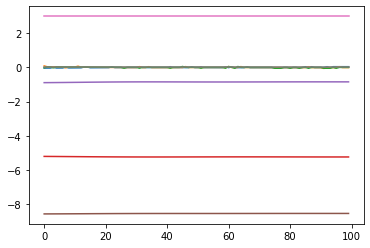

In [24]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:1100, i])

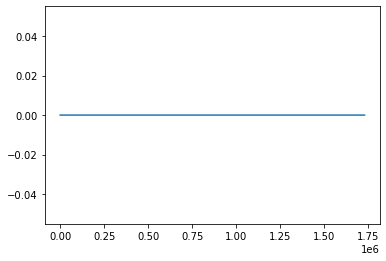

In [25]:
plt.plot(data[:, 7])

In [26]:
data

array([[-5.24999980e+00, -8.49999640e-01, -8.59999990e+00, ...,
        -3.00179340e-12,  3.00000000e+00,  0.00000000e+00],
       [-5.24999980e+00, -8.99999650e-01, -8.54999970e+00, ...,
        -6.07596669e-11,  3.00000000e+00,  0.00000000e+00],
       [-5.19999980e+00, -8.99999650e-01, -8.54999970e+00, ...,
        -6.14167625e-10,  3.00000000e+00,  0.00000000e+00],
       ...,
       [-8.05811937e-01, -2.26359896e+00, -1.12345261e+00, ...,
        -2.67654699e+00,  3.00000000e+00,  0.00000000e+00],
       [-1.36929024e+00, -1.83528455e+00, -8.63163615e-01, ...,
        -2.68683598e+00,  3.00000000e+00,  0.00000000e+00],
       [-5.83097181e-01, -2.25585532e+00, -8.01118237e-01, ...,
        -2.69888136e+00,  3.00000000e+00,  0.00000000e+00]])